# Anonymization Procedure for SWMM .inp with Geo Located Coordinate Systems

***NOTE***: this entire procedure has been wrapped into a method in swwmWrangle. To see an example of how that is used, please see [Anonymize Full Routine](https://github.com/kLabUM/AnonymizeINP/blob/master/AnonymizeFullRoutine.ipynb).

![](TRANSLATION_INPUT.PNG)

**Motivation**: Remove any geolocated signatures from a SWMM .inp. This process can perform translation, rotation, and scaling of coordinates, then output them in a .inp-friendly format. The following SWMM .inp sections contain coordinate information:

- [MAP]: defines the boundaries of the map and the unit of the map.
- [COORDINATES]: lists (x,y) coordinates for nodes.
- [VERTICES]: I don't know what these do. I think they are the lines of conduits.
- [Polygons]: Defines shapes with list of (x,y) like subcatchments.
- [SYMBOLS]: (x,y) for rain gains and other images.

In [2]:
import swmmWrangle as sm
import matplotlib.pyplot as plt
import random
import math
from affine import Affine
from collections import OrderedDict


inpF = 'YOUR_INP_FILE_HERE.inp'
outF = inpF[:-3]+'out'


model = sm.swmmINP(inpF,offset=0.0)
model.set_dicts()
model.set_geo_dicts()

# Rotate (x,y) singles 

In [33]:
Rotation_Angle = random.random()*360

A_rot = Affine.rotation(Rotation_Angle)

# Rotate Nodes
for node in model.coords:
    model.coords[node]['xy_1'] = A_rot * model.coords[node]['xy']

# Rotate Symbols
for sym in model.symbols:
    model.symbols[sym]['xy_1'] = A_rot * model.symbols[sym]['xy']
    
# Rotate Vertices
for v in model.verts:
    model.verts[v]['xy_1'] = []
    for tup in model.verts[v]['xy']:
        model.verts[v]['xy_1'].append(A_rot * tup)
        
# Rotate Polygons
for p in model.polygons:
    model.polygons[p]['xy_1'] = []
    for tup in model.polygons[p]['xy']:
        model.polygons[p]['xy_1'].append(A_rot * tup)

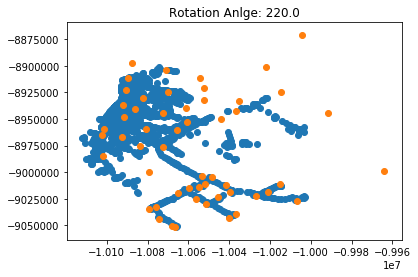

In [34]:
xys = [model.coords[i]['xy_1'] for i in model.coords]
syms = [model.symbols[i]['xy_1'] for i in model.symbols]

plt.scatter(*zip(*xys))
plt.scatter(*zip(*syms))
plt.title("Rotation Anlge: {0}".format(str(round(Rotation_Angle,0))))
plt.show()

# Find Max and Min Coords after Rotation

In [35]:
x_min = math.inf
x_max = -math.inf
y_min = math.inf
y_max = -math.inf


for n in model.coords:
    
    # Min
    if model.coords[n]['xy_1'][0] < x_min:
        x_min = model.coords[n]['xy_1'][0]
    if model.coords[n]['xy_1'][1] < y_min:
        y_min = model.coords[n]['xy_1'][1]
        
    # Max
    if model.coords[n]['xy_1'][0] > x_max:
        x_max = model.coords[n]['xy_1'][0]
    if model.coords[n]['xy_1'][1] > y_max:
        y_max = model.coords[n]['xy_1'][1]
    
for s in model.symbols:
    
    # Min
    if model.symbols[s]['xy_1'][0] < x_min:
        x_min = model.symbols[s]['xy_1'][0]
    if model.symbols[s]['xy_1'][1] < y_min:
        y_min = model.symbols[s]['xy_1'][1]
        
    # Max
    if model.symbols[s]['xy_1'][0] > x_max:
        x_max = model.symbols[s]['xy_1'][0]
    if model.symbols[s]['xy_1'][1] > y_max:
        y_max = model.symbols[s]['xy_1'][1]
        
for p in model.polygons:
    for tup in model.polygons[p]['xy_1']:
        
        # Min
        if tup[0] < x_min:
            x_min = tup[0]
        if tup[1] < y_min:
            y_min = tup[0]
            
        # Max
        if tup[0] > x_max:
            x_max = tup[0]
        if tup[1] > y_max:
            y_max = tup[1]
            
            
for v in model.verts:
    for tup in model.verts[v]['xy_1']:
        
        # Min
        if tup[0] < x_min:
            x_min = tup[0]
        if tup[1] < y_min:
            y_min = tup[1]
            
        # Max
        if tup[0] > x_max:
            x_max = tup[0]
        if tup[1] > y_max:
            y_max = tup[1]


# Scaling
Motivation is to get all maps into the same range of total distances -- that way cities cannot be determined via absolute distances of their windows.

In [36]:
x_scale = 100000/(x_max - x_min)
y_scale = 100000/(y_max - y_min)

A_scale = Affine.scale(x_scale,y_scale)

for node in model.coords:
    model.coords[node]['xy_2'] = A_scale * model.coords[node]['xy_1']
    
for sym in model.symbols:
    model.symbols[sym]['xy_2'] = A_scale * model.symbols[sym]['xy_1']

for p in model.polygons:
    model.polygons[p]['xy_2'] = []
    for tup in model.polygons[p]['xy_1']:
        model.polygons[p]['xy_2'].append(A_scale * tup)
        
for v in model.verts:
    model.verts[v]['xy_2'] = []
    for tup in model.verts[v]['xy_1']:
        model.verts[v]['xy_2'].append(A_scale * tup)

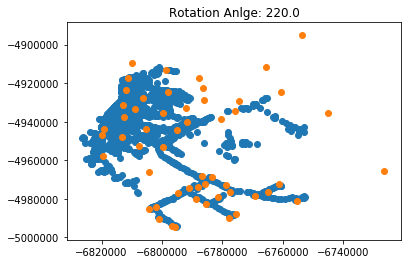

In [37]:
xys = [model.coords[i]['xy_2'] for i in model.coords]
syms = [model.symbols[i]['xy_2'] for i in model.symbols]

plt.scatter(*zip(*xys))
plt.scatter(*zip(*syms))
plt.title("Rotation Anlge: {0}".format(str(round(Rotation_Angle,0))))
# plt.xlim([0, 1.05 * (x_max + x_trans)])
# plt.ylim([0, 1.05 * (y_max + y_trans)])
plt.show()

# Find Max and Min Coords after Rotation

In [38]:
x_min = math.inf
x_max = -math.inf
y_min = math.inf
y_max = -math.inf


for n in model.coords:
    
    # Min
    if model.coords[n]['xy_2'][0] < x_min:
        x_min = model.coords[n]['xy_2'][0]
    if model.coords[n]['xy_2'][1] < y_min:
        y_min = model.coords[n]['xy_2'][1]
        
    # Max
    if model.coords[n]['xy_2'][0] > x_max:
        x_max = model.coords[n]['xy_2'][0]
    if model.coords[n]['xy_2'][1] > y_max:
        y_max = model.coords[n]['xy_2'][1]
    
for s in model.symbols:
    
    # Min
    if model.symbols[s]['xy_2'][0] < x_min:
        x_min = model.symbols[s]['xy_2'][0]
    if model.symbols[s]['xy_2'][1] < y_min:
        y_min = model.symbols[s]['xy_2'][1]
        
    # Max
    if model.symbols[s]['xy_2'][0] > x_max:
        x_max = model.symbols[s]['xy_2'][0]
    if model.symbols[s]['xy_2'][1] > y_max:
        y_max = model.symbols[s]['xy_2'][1]
        
for p in model.polygons:
    for tup in model.polygons[p]['xy_2']:
        
        # Min
        if tup[0] < x_min:
            x_min = tup[0]
        if tup[1] < y_min:
            y_min = tup[0]
            
        # Max
        if tup[0] > x_max:
            x_max = tup[0]
        if tup[1] > y_max:
            y_max = tup[1]
            
            
for v in model.verts:
    for tup in model.verts[v]['xy_2']:
        
        # Min
        if tup[0] < x_min:
            x_min = tup[0]
        if tup[1] < y_min:
            y_min = tup[1]
            
        # Max
        if tup[0] > x_max:
            x_max = tup[0]
        if tup[1] > y_max:
            y_max = tup[1]


# Translation
(0,0) will be new minimum and will set as such in the map dimensions window. However, we'll translate with a padding in order for the visuals to not look too tight.

In [39]:
x_trans = -x_min + 0.05 * (x_max - x_min)
y_trans = -y_min + 0.05 * (y_max - y_min)
print(x_trans,y_trans)

A_trans = Affine.translation(x_trans,y_trans)

for node in model.coords:
    model.coords[node]['xy_3'] = A_trans * model.coords[node]['xy_2']
    
for sym in model.symbols:
    model.symbols[sym]['xy_3'] = A_trans * model.symbols[sym]['xy_2']

for p in model.polygons:
    model.polygons[p]['xy_3'] = []
    for tup in model.polygons[p]['xy_2']:
        model.polygons[p]['xy_3'].append(A_trans * tup)
        
for v in model.verts:
    model.verts[v]['xy_3'] = []
    for tup in model.verts[v]['xy_2']:
        model.verts[v]['xy_3'].append(A_trans * tup)


6831535.183383088 4999882.190860101


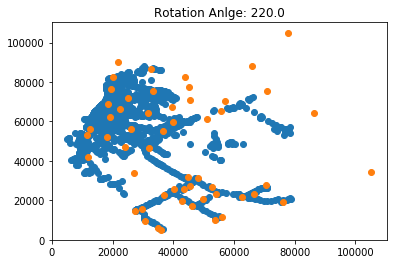

In [40]:
xys = [model.coords[i]['xy_3'] for i in model.coords]
syms = [model.symbols[i]['xy_3'] for i in model.symbols]

plt.scatter(*zip(*xys))
plt.scatter(*zip(*syms))
plt.title("Rotation Anlge: {0}".format(str(round(Rotation_Angle,0))))
plt.xlim([0, 1.05 * (x_max + x_trans)])
plt.ylim([0, 1.05 * (y_max + y_trans)])
plt.show()

# Define New Map Dimensions

In [87]:
model.map['dim_transformed'] = [0,0,1.05 * (x_max + x_trans),1.05 * (y_max + y_trans)]

# Output Sections in the Following Order

- MAP
- COORDINATES
- VERTICES
- POLYGONS
- SYMBOLS

In [81]:
# Write [MAP] section
with open('MAP.txt','w') as f:
    f.write('[MAP]\n')
    
    f.write('DIMENSIONS')
    for i in model.map['dim_transformed']:
        f.write(' ' + str(i))
    f.write('\n')
        
    f.write('Units\t {0}\n'.format(model.map['units']))

In [82]:
# Write [COORDINATES] section

with open('COORDINATES.txt','w') as f:
    f.write('[COORDINATES]\n')
    f.write(';;Node           X-Coord            Y-Coord           \n')
    f.write(';;-------------- ------------------ ------------------\n')
                    
    for n in model.coords:
        wrt = '{0}\t\t{1}\t\t{2}\n'.format(
            n,
            model.coords[n]['xy_3'][0],
            model.coords[n]['xy_3'][1]
        )
#         wrt = n + '\t\t' + str() + '\t\t' + str() + '\n'
        f.write(wrt)

In [83]:
# Write Symbols

with open('SYMBOLS.txt','w') as f:
    f.write('[SYMBOLS]\n')
    f.write(';;Gage           X-Coord            Y-Coord           \n')
    f.write(';;-------------- ------------------ ------------------\n')
    
    for s in model.symbols:
        wrt = '{0}\t\t{1}\t\t{2}\n'.format(
            s,
            model.symbols[s]['xy_3'][0],
            model.symbols[s]['xy_3'][1]
        )
        f.write(wrt)

In [84]:
# Write Polygons

with open('POLYGONS.txt','w') as f:
    f.write('[POLYGONS]\n')
    f.write(';;Subcatchment   X-Coord            Y-Coord           \n')
    f.write(';;-------------- ------------------ ------------------\n')

    for p in model.polygons:
        for xy in model.polygons[p]['xy_3']:
            wrt = '{0}\t\t{1}\t\t{2}\n'.format(
                p,
                xy[0],
                xy[1]
            )
            f.write(wrt)

In [85]:
# Write Vertices

with open('VERTICES.txt','w') as f:
    f.write('[VERTICES]\n')
    f.write(';;Link           X-Coord            Y-Coord           \n')
    f.write(';;-------------- ------------------ ------------------\n')

    for v in model.verts:
        for xy in model.verts[v]['xy_3']:
            wrt = '{0}\t\t{1}\t\t{2}\n'.format(
                v,
                xy[0],
                xy[1]
            )
            f.write(wrt)

In [86]:
txts = [
    'MAP.txt',
    'COORDINATES.txt',
    'VERTICES.txt',
    'POLYGONS.txt',
    'SYMBOLS.txt'
]

with open('GeoSections.txt','w') as fout:
    for txt in txts:
        fout.write('\n')
        with open(txt) as fin:
            for l in fin:
                fout.write(l)
    

# Next Steps

You're done text wrangling in Python! Now open the text file you created and copy and paste those sections into a copy of your base .inp file. Up up in SWMM and you get something like this:

![](TRANSLATION_OUTPUT.PNG)